# Full Implementation of Metropolis-Hastings with Particle Filter
This notebook implements the Metropolis-Hastings algorithm with particle filtering (PFMCMC), faithfully reproducing the results from the article *Fitting complex population models by combining particle filters
with Markov chain Monte Carlo* (2012) by Jonas Knape and Perry de Valpine. It includes:
- Adaptive Metropolis-Hastings with density proposals.
- Particle filtering for likelihood estimation.
- Post-analysis of parameter estimates and state estimation.

In [12]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import multivariate_normal
from scipy.special import gammaln
from sklearn.cluster import KMeans
from scipy.stats import norm

Progress |####################| 100%
Done.


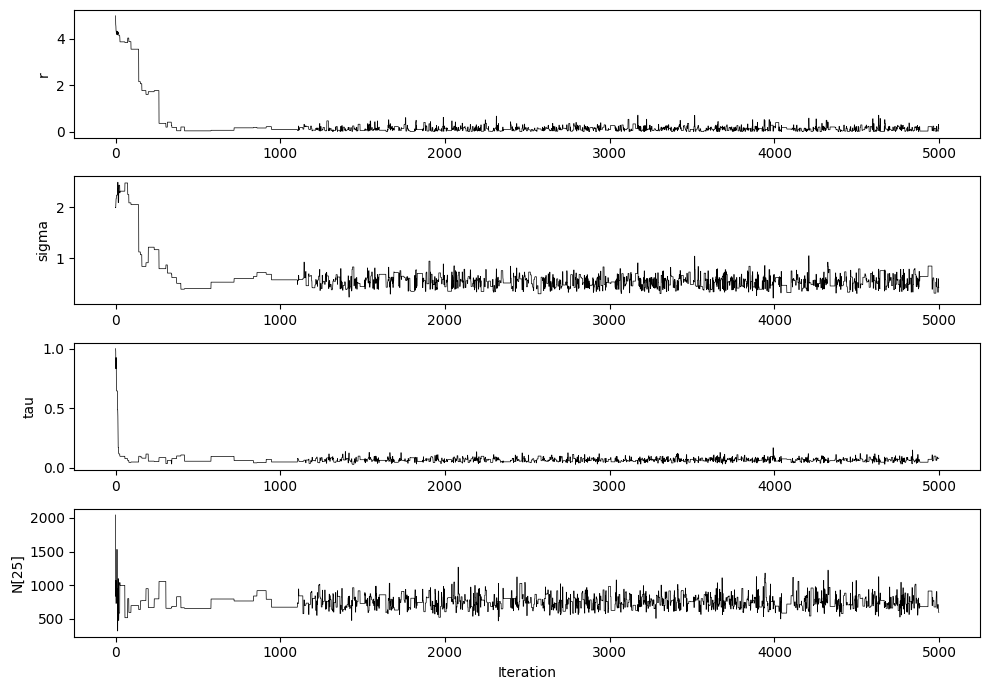

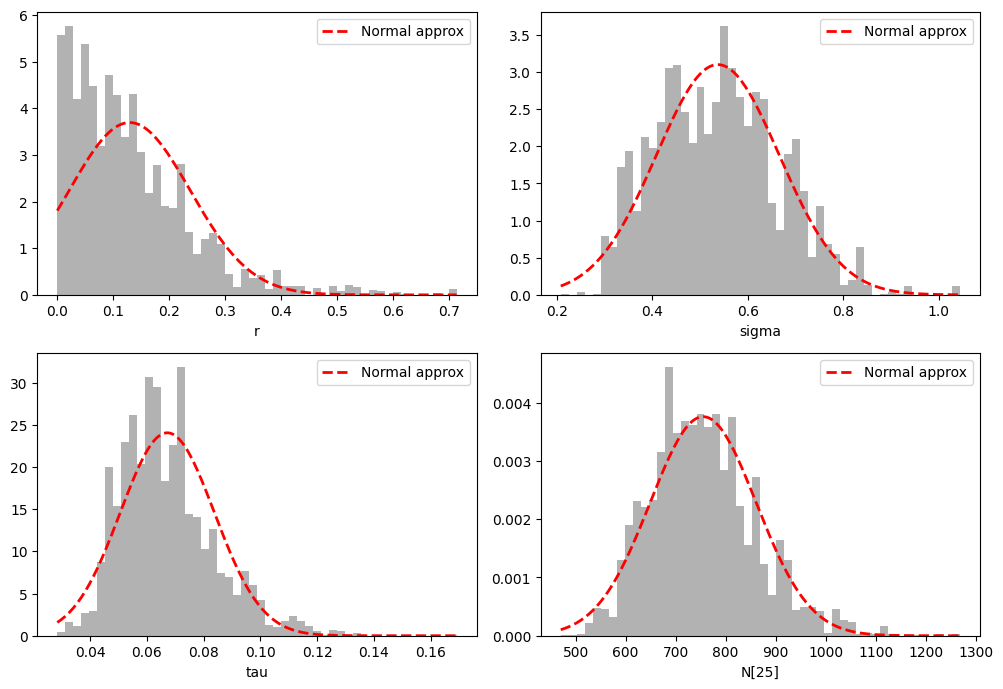

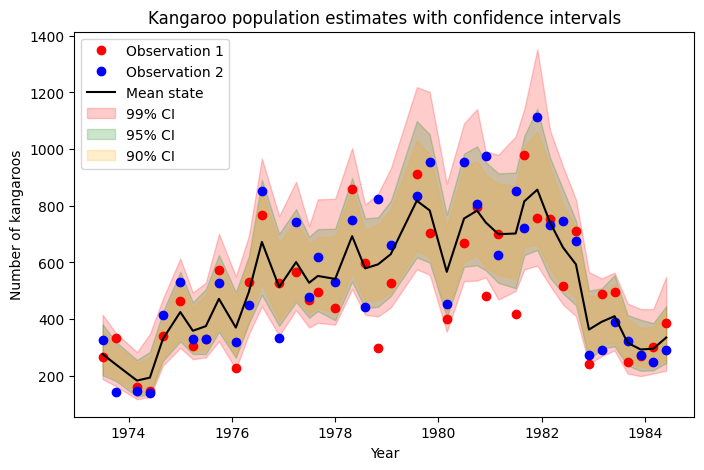

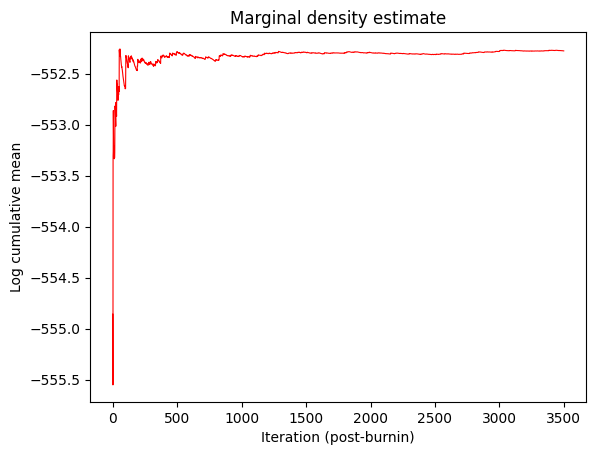

Approx. marginal density = -552.2757541202096


In [13]:
##############################################################################
# 1) Functions for normal mixtures (adaptive MH proposals)
##############################################################################

def mixtureDensity(x, mixture, log=False):
    """
    Computes the density of a normal mixture at a point x.
    If 'log=True', returns the log density; otherwise, the normal scale density.
    """
    if "w" not in mixture or mixture["w"] is None or len(mixture["w"]) == 0:
        # Simple normal distribution
        mean_ = mixture["m"]
        cov_ = mixture["V"]
        d = multivariate_normal.pdf(x, mean=mean_, cov=cov_)
    else:
        # Mixture of multiple components
        w = mixture["w"]
        d = 0.0
        for i in range(len(w)):
            d += w[i] * mixtureDensity(x, mixture=mixture["comp"][i], log=False)
    return np.log(d) if log else d

def mixtureSim(mixture):
    """
    Generates a sample (vector) from the given normal mixture.
    """
    if "w" not in mixture or mixture["w"] is None or len(mixture["w"]) == 0:
        # Simple normal distribution
        mean_ = mixture["m"]
        cov_ = mixture["V"]
        return multivariate_normal.rvs(mean=mean_, cov=cov_)
    else:
        w = mixture["w"]
        c = np.random.choice(range(len(w)), p=w)
        return mixtureSim(mixture["comp"][c])

def mixtlikapproximation(ptrace, nComp):
    """
    Fits a Gaussian mixture using K-means clustering and calculates the BIC.
    ptrace: (d, n)
    nComp: number of components
    Returns a dict {"density": ..., "BIC": ...}
    """
    d, n = ptrace.shape
    cov_mat = np.cov(ptrace.T, rowvar=False)
    chL = np.linalg.cholesky(cov_mat).T
    chLinv = np.linalg.inv(chL)

    transformed = (chLinv @ ptrace).T  # shape (n, d)
    km = KMeans(n_clusters=nComp, n_init=20).fit(transformed)
    labels = km.labels_
    pw = np.bincount(labels) / n

    means = np.zeros((nComp, d))
    covs = np.zeros((nComp, d, d))
    lik = np.zeros((nComp, n))

    # Compute means / covariances for each cluster
    for i in range(nComp):
        subset = ptrace[:, labels == i]
        means[i, :] = np.mean(subset, axis=1)
        covs[i, :, :] = np.cov(subset.T, rowvar=False)

    # Overall log-likelihood
    for i in range(nComp):
        pdf_vals = multivariate_normal.pdf(ptrace.T, mean=means[i, :], cov=covs[i, :, :])
        lik[i, :] = pw[i] * pdf_vals

    llik = np.sum(np.log(np.sum(lik, axis=0)))
    BIC = -2.0 * llik + (nComp * (d*(d+1)/2.0 + d + 1)) * np.log(n)

    if nComp == 1:
        density = {"m": means[0, :], "V": covs[0, :, :]}
    else:
        comp_list = []
        for i in range(nComp):
            comp_list.append({"m": means[i, :], "V": covs[i, :, :]})
        density = {"w": pw, "comp": comp_list}

    return {"density": density, "BIC": BIC}

def getPropDensity(ptrace, k, w, maxComp):
    """
    Builds a normal mixture with two main components:
    - A "regular" mixture
    - An "inflated variance" mixture
    The number of components inside each mixture is determined by BIC.
    """
    BIC_vals = []
    denslist = []
    for i in range(1, maxComp+1):
        try:
            ml = mixtlikapproximation(ptrace, i)
            if np.isnan(ml["BIC"]):
                ml = mixtlikapproximation(ptrace, i)  # Retry if needed
        except:
            ml = {"density": None, "BIC": np.inf}

        BIC_vals.append(ml["BIC"])
        denslist.append(ml["density"])

    idx_best = np.argmin(BIC_vals)
    best_nComp = idx_best + 1
    best_density = denslist[idx_best]

    # Build the "inflated" version
    if best_nComp == 1:
        extdensity = {"m": best_density["m"], "V": k * best_density["V"]}
    else:
        new_comps = []
        for comp_i in best_density["comp"]:
            new_comps.append({"m": comp_i["m"], "V": k * comp_i["V"]})
        extdensity = {"w": best_density["w"], "comp": new_comps}

    mixture = {
        "w": [w, 1 - w],
        "comp": [best_density, extdensity]
    }
    return mixture

##############################################################################
# 2) Particle filter and priors
##############################################################################

from scipy.special import gammaln

def dnegbin(y, mu, tau):
    """
    Computes the log-density of a Negative Binomial distribution (mu, tau parameterization).
    y, mu can be scalars or arrays. Broadcasting is enforced.
    """
    y = np.array(y, dtype=float)
    mu = np.array(mu, dtype=float)
    y, mu = np.broadcast_arrays(y, mu)

    term1 = gammaln(y + 1.0 / tau)
    term2 = gammaln(y + 1.0)
    term3 = gammaln(1.0 / tau)
    logP = term1 - term2 - term3

    logP = logP - (y + 1.0 / tau) * np.log(1.0 + mu * tau)
    logP = logP + y * np.log(mu * tau)

    # Replace NaNs with -inf
    logP = np.where(np.isnan(logP), -np.inf, logP)
    return logP

def prior(p):
    """
    Uniform priors:
      r ~ U(-10, 10)
      s ~ U(0, 10)
      tau ~ U(0, 10)
    """
    r, s, tau = p
    rmax = 10
    smax = 10
    taumax = 10
    cond_r = (abs(r) < rmax)
    cond_s = (0 < s < smax)
    cond_tau = (0 < tau < taumax)

    if not (cond_r and cond_s and cond_tau):
        return -np.inf

    # log(1/(2*rmax)) + log(1/smax) + log(1/taumax)
    lp = np.log(1/(2*rmax)) + np.log(1/smax) + np.log(1/taumax)
    return lp

def particleFilterLL(y, p, N):
    """
    Particle filter for:
      x[t+1] ~ Normal(x[t] + r*Delta_t, s^2*Delta_t)
      y[1,t], y[2,t] ~ NegBin(mean=exp(x[t]), tau)
    """
    if np.min(p) < 0:
        return {"LL": -np.inf, "rN": None}

    r, s, tau = p
    T = y.shape[1]
    x = np.zeros((N, T))
    P = np.zeros(T)

    # Initialization: x ~ N(5, 10^2)
    x[:, 0] = np.random.normal(5, 10, N)

    logW = dnegbin(y[0, 0], np.exp(x[:, 0]), tau) + dnegbin(y[1, 0], np.exp(x[:, 0]), tau)
    logWMax = np.max(logW)
    scaledWeights = np.exp(logW - logWMax)
    P[0] = np.mean(scaledWeights) * np.exp(logWMax)

    if logWMax == -np.inf:
        return {"LL": -np.inf, "rN": None}

    ind = np.zeros((N, T), dtype=int)
    for t in range(1, T):
        W_norm = scaledWeights / np.sum(scaledWeights)
        indices_chosen = np.random.choice(N, size=N, p=W_norm, replace=True)
        ind[:, t-1] = indices_chosen

        delta_t = y[2, t] - y[2, t-1]
        x[:, t] = x[indices_chosen, t-1] + r * delta_t + s * np.sqrt(delta_t) * np.random.normal(0, 1, N)

        logW = dnegbin(y[0, t], np.exp(x[:, t]), tau) + dnegbin(y[1, t], np.exp(x[:, t]), tau)
        logWMax = np.max(logW)
        scaledWeights = np.exp(logW - logWMax)
        P[t] = np.mean(scaledWeights) * np.exp(logWMax)

        if logWMax == -np.inf:
            return {"LL": -np.inf, "rN": None}

    W_norm = scaledWeights / np.sum(scaledWeights)
    ind[:, T-1] = np.random.choice(N, size=N, p=W_norm, replace=True)

    rx = np.zeros(T)
    itrace = ind[0, T-1]
    rx[T-1] = x[itrace, T-1]
    for t in range(T-2, -1, -1):
        itrace = ind[itrace, t]
        rx[t] = x[itrace, t]

    LL_val = np.sum(np.log(P))
    return {"LL": LL_val, "rN": np.exp(rx)}

##############################################################################
# 3) Main part (adaptive MCMC + PF) - with normal overlay on histograms
##############################################################################

def simple_progress_bar(i, M):
    """
    Display a simple progress bar (optional).
    """
    frac = i / M
    bar_length = 20
    filled_length = int(round(bar_length * frac))
    bar = '#' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write(f'\rProgress |{bar}| {int(frac*100)}%')
    sys.stdout.flush()

# --------------------------------------------------------------------------
# DATA
# --------------------------------------------------------------------------
y_data = np.array([
    [267, 333, 159, 145, 340, 463, 305, 329, 575, 227, 532, 769, 526, 565, 466, 494, 440, 858, 599, 298, 529, 912, 703, 402,
     669, 796, 483, 700, 418, 979, 757, 755, 517, 710, 240, 490, 497, 250, 271, 303, 386],
    [326, 144, 145, 138, 413, 531, 331, 329, 529, 318, 449, 852, 332, 742, 479, 620, 531, 751, 442, 824, 660, 834, 955, 453,
     953, 808, 975, 627, 851, 721, 1112, 731, 748, 675, 272, 292, 389, 323, 272, 248, 290],
    [1973.497, 1973.75, 1974.163, 1974.413, 1974.665, 1975.002, 1975.245, 1975.497, 1975.75,
     1976.078, 1976.33, 1976.582, 1976.917, 1977.245, 1977.497, 1977.665, 1978.002, 1978.33,
     1978.582, 1978.832, 1979.078, 1979.582, 1979.832, 1980.163, 1980.497, 1980.75, 1980.917,
     1981.163, 1981.497, 1981.665, 1981.917, 1982.163, 1982.413, 1982.665, 1982.917, 1983.163,
     1983.413, 1983.665, 1983.917, 1984.163, 1984.413]
], dtype=float)

# --------------------------------------------------------------------------
# PARAMETERS
# --------------------------------------------------------------------------
d = 3                # Number of parameters (r, s, tau)
M = 5000             # Total length of MCMC chain
N = 800              # Number of particles
inits = np.array([5.0, 2.0, 1.0])

# Adaptation phase
trs = 1000           # Adaptive RW length
w01 = 0.4
w02 = 0.5
k0  = 25

# Sequence for updating mixture proposal during the independence phase
updateSeq = [trs + x for x in range(1, 3000 - trs, 300)]
w1 = 0.8
k1 = 25
maxComp = 6

# --------------------------------------------------------------------------
# ALLOCATE STORAGE
# --------------------------------------------------------------------------
pars = np.zeros((d, M))
propPars = np.zeros((d, M))
states = np.zeros((y_data.shape[1], M))

LL = np.zeros(M)
priorLP = np.zeros(M)
genLP = np.zeros(M)
propLL = np.zeros(M)
propPriorLP = np.zeros(M)
propGenLP = np.zeros(M)

accepted = np.zeros(M)

# --------------------------------------------------------------------------
# INITIAL SETUP
# --------------------------------------------------------------------------
pars[:, 0] = inits
pf_out = particleFilterLL(y_data, pars[:, 0], N)
states[:, 0] = pf_out["rN"]
LL[0] = pf_out["LL"]
priorLP[0] = prior(pars[:, 0])
propDen = None

# --------------------------------------------------------------------------
# ADAPTIVE MCMC LOOP
# --------------------------------------------------------------------------
for i in range(1, M):
    # Step 1 : Build the proposal density
    if i <= trs:
        # Initial RW adaptation phase
        if np.sum(accepted[:i]) <= 2 * d:
            propDen = {"m": pars[:, i-1], "V": 0.1 * np.eye(d) / d}
        else:
            cov_mat = np.cov(pars[:, :i].T, rowvar=False)
            propDen = {
                "w": np.array([w01, w02, 1 - w01 - w02]),
                "comp": [
                    {"m": pars[:, i-1], "V": 0.1 * np.eye(d) / d},
                    {"m": pars[:, i-1], "V": (2.38**2) * cov_mat / d},
                    {"m": pars[:, i-1], "V": k0 * (2.38**2) * cov_mat / d}
                ]
            }
    else:
        # Independence phase
        if i in updateSeq:
            propDen = getPropDensity(pars[:, :i], k1, w1, maxComp)

    # Step 2 : Generate proposal
    propPars[:, i] = mixtureSim(propDen)
    pf_out_prop = particleFilterLL(y_data, propPars[:, i], N)
    propLL[i] = pf_out_prop["LL"]
    propPriorLP[i] = prior(propPars[:, i])
    propGenLP[i] = mixtureDensity(propPars[:, i], propDen, log=True)

    # Step 3 : Accept or reject
    alpha = propLL[i] + propPriorLP[i] - LL[i-1] - priorLP[i-1]
    if i > trs:
        alpha += (genLP[i-1] - propGenLP[i])

    if np.log(np.random.rand()) < alpha:
        # Accept
        states[:, i] = pf_out_prop["rN"]
        pars[:, i] = propPars[:, i]
        LL[i] = propLL[i]
        priorLP[i] = propPriorLP[i]
        genLP[i] = propGenLP[i]
        accepted[i] = 1
    else:
        # Reject
        states[:, i] = states[:, i-1]
        pars[:, i] = pars[:, i-1]
        LL[i] = LL[i-1]
        priorLP[i] = priorLP[i-1]
        genLP[i] = genLP[i-1]

    # Progress bar
    if (i % (M // 10) == 0):
        simple_progress_bar(i, M)

simple_progress_bar(M, M)
print("\nDone.")

# --------------------------------------------------------------------------
# ANALYSIS
# --------------------------------------------------------------------------
burnin = 1500  # Discard the first 1500 iterations
I = range(burnin, M)

# --------------------------------------------------------------------------
# TRACEPLOTS
# --------------------------------------------------------------------------
plt.figure(figsize=(10, 7))
plt.subplot(4, 1, 1)
plt.plot(pars[0, :], 'k-', lw=0.5)
plt.ylabel("r")

plt.subplot(4, 1, 2)
plt.plot(pars[1, :], 'k-', lw=0.5)
plt.ylabel("sigma")

plt.subplot(4, 1, 3)
plt.plot(pars[2, :], 'k-', lw=0.5)
plt.ylabel("tau")

plt.subplot(4, 1, 4)
plt.plot(states[24, :], 'k-', lw=0.5)
plt.ylabel("N[25]")
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------
# HISTOGRAMS and THEORETICAL NORMAL CURVE
# --------------------------------------------------------------------------
plt.figure(figsize=(10, 7))

# First parameter: r
plt.subplot(2, 2, 1)
vals_r = pars[0, I]
count, bins, _ = plt.hist(vals_r, bins=50, color='gray', alpha=0.6, density=True)
plt.xlabel("r")
# Normal approximation
mu_r, std_r = np.mean(vals_r), np.std(vals_r)
x_r = np.linspace(bins[0], bins[-1], 200)
pdf_r = norm.pdf(x_r, mu_r, std_r)
plt.plot(x_r, pdf_r, 'r--', lw=2, label="Normal approx")
plt.legend()

# Second parameter: sigma
plt.subplot(2, 2, 2)
vals_s = pars[1, I]
count, bins, _ = plt.hist(vals_s, bins=50, color='gray', alpha=0.6, density=True)
plt.xlabel("sigma")
# Normal approximation
mu_s, std_s = np.mean(vals_s), np.std(vals_s)
x_s = np.linspace(bins[0], bins[-1], 200)
pdf_s = norm.pdf(x_s, mu_s, std_s)
plt.plot(x_s, pdf_s, 'r--', lw=2, label="Normal approx")
plt.legend()

# Third parameter: tau
plt.subplot(2, 2, 3)
vals_t = pars[2, I]
count, bins, _ = plt.hist(vals_t, bins=50, color='gray', alpha=0.6, density=True)
plt.xlabel("tau")
# Normal approximation
mu_t, std_t = np.mean(vals_t), np.std(vals_t)
x_t = np.linspace(bins[0], bins[-1], 200)
pdf_t = norm.pdf(x_t, mu_t, std_t)
plt.plot(x_t, pdf_t, 'r--', lw=2, label="Normal approx")
plt.legend()

# State example: N[25]
plt.subplot(2, 2, 4)
vals_n25 = states[24, I]
count, bins, _ = plt.hist(vals_n25, bins=50, color='gray', alpha=0.6, density=True)
plt.xlabel("N[25]")
# Normal approximation
mu_n25, std_n25 = np.mean(vals_n25), np.std(vals_n25)
x_n25 = np.linspace(bins[0], bins[-1], 200)
pdf_n25 = norm.pdf(x_n25, mu_n25, std_n25)
plt.plot(x_n25, pdf_n25, 'r--', lw=2, label="Normal approx")
plt.legend()

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------
# POPULATION PREDICTION AND CONFIDENCE INTERVALS
# --------------------------------------------------------------------------
mean_state = np.mean(states[:, I], axis=1)
state_samples = states[:, I]  # shape = (T, num_samples)
time_points = y_data[2, :]

# Confidence intervals
CI_specs = [
    ("99%", 0.5, 99.5, 'red'),
    ("95%", 2.5, 97.5, 'green'),
    ("90%", 5.0, 95.0, 'orange')
]

plt.figure(figsize=(8, 5))
# Observations
plt.plot(time_points, y_data[0, :], 'ro', label="Observation 1")
plt.plot(time_points, y_data[1, :], 'bo', label="Observation 2")
# Mean
plt.plot(time_points, mean_state, 'k-', label="Mean state")

for label, qlow, qhigh, color_ in CI_specs:
    lower = np.percentile(state_samples, qlow, axis=1)
    upper = np.percentile(state_samples, qhigh, axis=1)
    plt.fill_between(time_points, lower, upper, color=color_, alpha=0.2, label=f"{label} CI")

plt.xlabel("Year")
plt.ylabel("Number of kangaroos")
plt.title("Kangaroo population estimates with confidence intervals")
plt.legend()
plt.show()

# --------------------------------------------------------------------------
# MARGINAL DENSITY ESTIMATE
# --------------------------------------------------------------------------
vals = propLL[I] + propPriorLP[I] - propGenLP[I]
cumval = np.cumsum(np.exp(vals)) / np.arange(1, len(vals)+1)
log_cumval = np.log(cumval)

plt.figure()
plt.plot(log_cumval, 'r-', lw=0.8)
plt.xlabel("Iteration (post-burnin)")
plt.ylabel("Log cumulative mean")
plt.title("Marginal density estimate")
plt.show()

margDens = np.log(np.mean(np.exp(vals)))
print("Approx. marginal density =", margDens)